In [113]:
from utils import *
from map_utils import *
from matplotlib import pyplot as plt
import pandas as pd
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel
import pickle
from sklearn.metrics import mean_squared_error

# 2D using location

In [137]:
points = get_points('../data/points_train.csv')
points['lat'] = points.geometry.y
points['lon'] = points.geometry.x

X = points[['lat', 'lon']].values
y = points['wait'].values

In [115]:
rbf = RBF([1.0, 1.0], length_scale_bounds=(1e-05, 100000.0)) # using anisotripic kernel
gp = GaussianProcessRegressor(kernel=rbf, n_restarts_optimizer=10, random_state=42)

In [116]:
gp.fit(X, y)

/home/till/miniconda3/envs/heatchmap/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/till/miniconda3/envs/heatchmap/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:445: ConvergenceWarning: The optimal value found for dimension 1 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


GaussianProcessRegressor(kernel=RBF(length_scale=[1, 1]),
                         n_restarts_optimizer=10, random_state=42)

In [117]:
with open('models/gp_model.pkl', 'wb') as f:
    pickle.dump(gp, f)
    

In [138]:
points['pred'], points['std'] = gp.predict(X, return_std=True)
mean_squared_error(points['wait'], points['pred'])

1.810021368971959e-13

In [119]:
gp = pickle.load(open('models/gp_model.pkl', 'rb'))

In [131]:
# validation
val = get_points('../data/points_val.csv')
val['lat'] = val.geometry.y
val['lon'] = val.geometry.x

X = val[['lat', 'lon']].values

In [133]:
val['pred'], val['std'] = gp.predict(X, return_std=True)
mean_squared_error(val['wait'], val['pred'])

5691.450701231915

In [135]:
val.pred.value_counts()


pred
0.000000     3283
52.997069       1
Name: count, dtype: int64

In [130]:
points

,lat,lon,wait,geometry,pred,std
0,5.977133e+06,2.042492e+06,10.0,POINT (2042491.509 5977132.610),10.0,0.00001
1,7.949040e+06,6.233234e+06,15.0,POINT (6233233.993 7949039.540),15.0,0.00001
2,6.704396e+06,8.452774e+05,50.0,POINT (845277.384 6704395.956),50.0,0.00001
3,6.984936e+06,3.059395e+06,15.0,POINT (3059394.655 6984936.465),15.0,0.00001
4,6.297111e+06,1.848286e+06,40.0,POINT (1848285.562 6297110.507),40.0,0.00001
...,...,...,...,...,...,...
9880,5.031539e+06,4.751149e+06,60.0,POINT (4751148.918 5031539.047),60.0,0.00001
9881,8.017535e+06,7.630933e+05,100.0,POINT (763093.307 8017535.477),100.0,0.00001
9882,4.922083e+06,9.465398e+05,30.0,POINT (946539.786 4922083.058),30.0,0.00001
9883,6.607101e+06,7.628277e+05,68.0,POINT (762827.718 6607100.845),68.0,0.00001


## map

In [122]:
region = 'germany'
val, polygon, map_boundary = get_points_in_region(val, region)
X, Y = get_map_grid(polygon, map_boundary)
grid = np.array((Y, X)).T

In [123]:
map = np.empty((0, X.shape[0]))

for vertical_line in tqdm(grid):
    pred, stdv = gp.predict(vertical_line, return_std=True)
    map = np.vstack((map, pred))
    

100%|██████████| 100/100 [00:36<00:00,  2.72it/s]


In [124]:
map = map.T

In [125]:
np.savetxt(f'intermediate/map_gp_{region}.txt', map)

In [126]:
map.shape

(70, 100)

In [127]:
Y.shape

(70, 100)

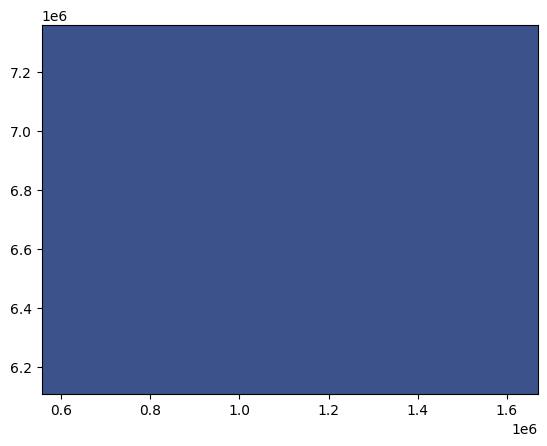

In [128]:
# preview
p = plt.contourf(X, Y, map)
plt.show()

# 3D using location and time when the spot was recorded (might use single ratings of spots here instead averaged)